In [1]:
import datetime, warnings, pickle, gc, os, math, pprint, hashlib, functools, joblib, binascii

import numpy  as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn           as sns

from IPython.display import display, display_html, Markdown

In [2]:
def hide_code_in_slideshow():
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display_html(html, raw=True)


In [3]:
def display_side_by_side(*args):
    """
    https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
    """
    html_str='<div style="text-align:center;">'
    for df in args:
        html_str+=df.to_html()
    html_str+="</div>"
    display_html(html_str.replace('table','table style="display:inline; margin-right:23px;"'),raw=True)

In [4]:
d2018 = pd.read_csv("raphapinheiro_quem-le-quadrinhos-em-2018.csv", delimiter=",", encoding="utf-8")
d2019 = pd.read_csv("raphapinheiro_quem-le-quadrinhos-em-2019.csv", delimiter=",", encoding="utf-8")
d2020 = pd.read_csv("raphapinheiro_quem-le-quadrinhos-em-2020.csv", delimiter=",", encoding="utf-8")

for d in [d2018, d2019, d2020]:
    d.columns = map(str.lower, d.columns)
    
d2018_meta = joblib.load("d2018_meta.jl")
d2019_meta = joblib.load("d2019_meta.jl")
d2020_meta = joblib.load("d2020_meta.jl")

# "Quem Lê Quadrinhos?"

O objetivo desta apresentação é explorar os resultados da ["Pesquisa de Leitores de Quadrinhos"](https://www.raphapinheiro.com/recursos), organizada anualmente pelo quadrinista [Rapha Pinheiro](https://www.youtube.com/channel/UCyRJv_q5RTWF6MT49YG_PhA).

<div style="border: 1px dashed #bebebe"><img src="img/img0.png" /></div>
<br/>

Não pretendo me preocupar com detalhes técnicos - como por exemplo eventuais vieses de amostragem. **O espírito aqui é o de usar algumas ideias de ciência de dados de forma intuitiva** em busca de insights complementares aos das análises mais gráficas.

# Tratamento de Dados

## Unificando Colunas

A primeira coisa que fiz foi tentar compilar os resultados de 2018-2020 em uma tabela só. 

A pesquisa evoluiu no tempo, perdendo algumas questões e ganhando outras. Além disso algumas perguntas ficaram mais abrangentes.

Por exemplo a pergunta sobre a influência de indicação de youtubers da pesquisa de 2018 abre o leque de mídias no ano seguinte:

In [5]:
q1 = "você costuma comprar os quadrinhos indicados pelos youtubers?"
q2 = "você costuma comprar quadrinhos indicados por " \
     + "youtubers/podcasters ou figuras da mídia especializada?"
display_side_by_side(d2018[[q1]].sample(3), d2019[[q2]].sample(3))

,você costuma comprar os quadrinhos indicados pelos youtubers?
449,Sim
3,Não
1533,Sim
,você costuma comprar quadrinhos indicados por youtubers/podcasters ou figuras da mídia especializada?
1266,Sim
3324,Não
1161,Sim


Outro exemplo de necessidade de tratamento é o de perguntas conceitualmente idênticas, mas escritas de forma **quase** idênticas em diferentes pesquisas, como é o caso da questão de estado de origem:

In [6]:
display_side_by_side(d2018[["qual seu estado de origem?"]].sample(3), 
                     d2019[["qual o seu estado de origem?"]].sample(3))

,qual seu estado de origem?
356,Panará (PR)
1603,São Paulo (SP)
368,Pernambuco (PE)
,qual o seu estado de origem?
3183,São Paulo (SP)
2260,São Paulo (SP)
1478,São Paulo (SP)


Pra lidar com isso escolhi **renomear todas as colunas** de modo que perguntas parecidas sejam identificadas por um mesmo rótulo.

A princípio essa é uma boa abordagem, mas tem alguns problemas incontornáveis - por exemplo como é o caso das perguntas que ficam mais abrangentes. Mas entre a união de conceitos ou não usar a informação, escolhi a união.

- - -

Ao longo da apresentação eu tento deixar clara a relação entre os nomes antigos e os novos, mas em todo caso, para mais detalhes sobre isso por favor consulte o notebook ["0_tratamento.ipynb"](https://github.com/thiagodsd/science-avec-des/blob/master/_gibi/0_tratamento.ipynb).

In [7]:
d2018.columns = map(str.lower, d2018.columns)
d2018         = d2018.rename(columns=d2018_meta)
d2018['ano']  = 2018
d2019.columns = map(str.lower, d2019.columns)
d2019         = d2019.rename(columns=d2019_meta)
d2019['ano']  = 2019
d2020.columns = map(str.lower, d2020.columns)
d2020         = d2020.rename(columns=d2020_meta)
d2020['ano']  = 2020

In [8]:
display( sorted(d2018['perfil_idade'].unique()) )
display( d2019['perfil_idade'].unique() )
display( d2020['perfil_idade'].unique() )

['13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

array([10., 12., 13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.,
       24., 25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36.,
       37., 38., 39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49.,
       50., 51., 52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62.,
       63., 64., 67., 68., nan, 11.])

array([15., 23., 20., 19., 21., 26., 17., 29., 24., 18., 14., 33., 16.,
       25., 35., 40., 34., 43., 42., 22., 32., 31., 38., 27., 28., 47.,
       52., 44., 41., 36., 48., 53., 13., 51., 46., 50., 39., 12., 59.,
       30., 45., 37., 49., 55., 58., 62., 54., 57., 66., nan, 60.])

In [9]:
d2018['perfil_idade_bin'] = d2018['perfil_idade']

col  = 'perfil_idade'
lab  = ['12-', '13-17', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']

cond = [
        (d2019[col] < 13),
        (d2019[col] >= 13) & (d2019[col] <= 17),
        (d2019[col] >= 18) & (d2019[col] <= 24),
        (d2019[col] >= 25) & (d2019[col] <= 34),
        (d2019[col] >= 35) & (d2019[col] <= 44),
        (d2019[col] >= 45) & (d2019[col] <= 54),
        (d2019[col] >= 55) & (d2019[col] <= 64),
        (d2019[col] >= 55)
       ]
d2019['perfil_idade_bin'] = np.select(cond, lab, default='None')

cond = [
        (d2020[col] < 13),
        (d2020[col] >= 13) & (d2020[col] <= 17),
        (d2020[col] >= 18) & (d2020[col] <= 24),
        (d2020[col] >= 25) & (d2020[col] <= 34),
        (d2020[col] >= 35) & (d2020[col] <= 44),
        (d2020[col] >= 45) & (d2020[col] <= 54),
        (d2020[col] >= 55) & (d2020[col] <= 64),
        (d2020[col] >= 55)
       ]
d2020['perfil_idade_bin'] = np.select(cond, lab, default='None')

In [10]:
data = pd.DataFrame(columns=set(d2018.columns.tolist() + d2019.columns.tolist() + d2020.columns.tolist()))
data = data.append(d2018[~d2018.timestamp.isnull()])
data = data.append(d2019[~d2019.timestamp.isnull()])
data = data.append(d2020[~d2020.timestamp.isnull()])

# Perfil

In [11]:
paltt = ["#120078", "#9d0191", "#fd3a69", "#fecd1a"]
sns.set_palette(sns.color_palette(paltt)) # https://colorhunt.co/palette/220041
display( sns.color_palette() )

[(0.07058823529411765, 0.0, 0.47058823529411764),
 (0.615686274509804, 0.00392156862745098, 0.5686274509803921),
 (0.9921568627450981, 0.22745098039215686, 0.4117647058823529),
 (0.996078431372549, 0.803921568627451, 0.10196078431372549)]

## Idade

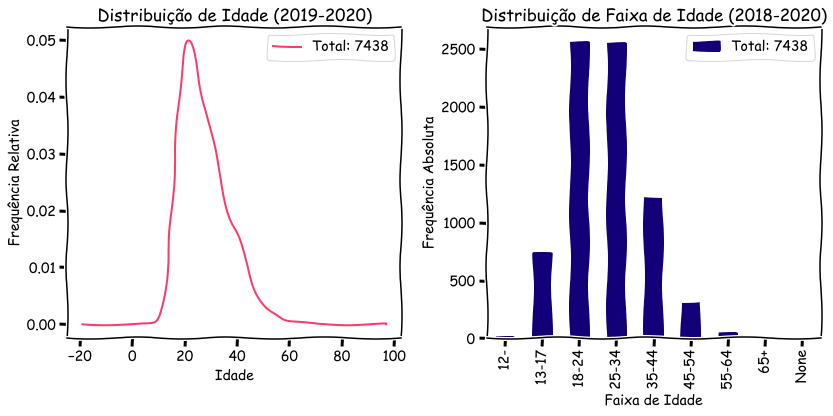

In [12]:
with plt.xkcd(randomness=0.5):
    fig, ((ax2, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    
    data.perfil_idade_bin.value_counts().sort_index().plot(
        kind='bar',
        label=rf"Total: {data.shape[0]}",
        ax=ax1
    )
    ax1.set_title('Distribuição de Faixa de Idade (2018-2020)')
    ax1.set_xlabel('Faixa de Idade')
    ax1.set_ylabel('Frequência Absoluta')
    ax1.legend()
    #
    data[data['ano'].isin([2019,2020])].perfil_idade.astype(np.float64).plot(
        kind='kde',
        color=paltt[2],
        label=rf"Total: {data.shape[0]}",
        ax=ax2
    )
    ax2.set_title('Distribuição de Idade (2019-2020)')
    ax2.set_xlabel('Idade')
    ax2.set_ylabel('Frequência Relativa')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig("img/plot0.png", dpi=100)

## Idade

Para os anos de 2019 e 2020 a idade é respondida como número - em contraste a 2018, onde é respondido como faixa de idade.

A resposta como número é interessante pela possibilidade de cáculo de estatísticas mais simples como média e desvio padrão:

In [13]:
mask = data['ano'].isin([2019,2020])
tab  = data[mask][['perfil_idade']].astype(np.float64)
display_side_by_side(tab.describe().T.round(3))

,count,mean,std,min,25%,50%,75%,max
perfil_idade,5692.0,27.586,9.022,10.0,21.0,26.0,33.0,68.0


Nas distribuições de idades em formato de número a gente vê o pico próximo de 20 anos, mas ao agrupar os valores de idade em faixas a concentração entre 18 e 35 anos fica mais evidente, dando a sensação de que "jovens jovens" e "jovens maduros" têm a mesma "importância" em termos de volume.

![legenda](img/plot0.png)